In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 'Advanced' Astronomy Tasks - A. Loh
Throughout this tutorial, we will use many inputs from the tutorial 'Introduction to Astropy', be sure to check it out! 

### What we will cover here
This tutorial will guide you through the whole process of getting a 'ready-to-publish' astronomical image using Python.
We will see how:
* Query an online astronomical database;
* Read and manipulate a source catalogue (3FGL Fermi-LAT catalogue as an example);
* Create a publishable map with every required features. 

**Please, follow this guide carefully as some sections will need previously computed results. You also need to have internet access. Two modules that we are going to use do not come with the standard Anaconda installation, please install them by typing in your terminal:**

In [ ]:
%%bash
pip install astroquery
pip install wcsaxes

### Online documentation
Like almost everything with Python, internet is your friend! Here are some usefull links for this tutorial (although many references are linked in the following):
* [Astroquery](https://pypi.python.org/pypi/astroquery/0.2.3)
* [Simbad queries](http://astroquery.readthedocs.org/en/latest/simbad/simbad.html)
* [SkyCoord](http://astropy.readthedocs.org/en/latest/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.separation)
* [Astropy](http://astropy.readthedocs.org/en/stable/)

## Astronomical Database Query using Astroquery
Astroquery is a very powerful package designed to acces online astronomical databases like Simbad, Vizier, NED and many others... Many examples can be found on the [Gallery of Queries](http://astroquery.readthedocs.org/en/latest/gallery.html).


### Simbad Simple Query
As an example here, we will query the Simbad database and search for our favorite source (by entering its identifier or coordinates with the format "05h35m17.3s -05h23m28s" for instance). It requires a call to the `query_object` method from the `Simbad` module (which is common to most of the database modules):

In [ ]:
from astroquery.simbad import Simbad

mysource = Simbad.query_object('Cyg X-3')

print mysource

...or find all the listed objects in Simbad lying within a given radius of your source/coordinates. Here we use two different methods to specify the angular size of the region, defined by the keyword `radius` (by default, its value is 20 arcmin).

In [ ]:
import astropy.units as u

results = Simbad.query_region('Cyg X-3', radius=2 * u.arcmin)

# Here is another way of specifying the radius, stricly equivalent
results = Simbad.query_region('Cyg X-3', radius='0d2m0s')

print(results)

Once `results` is created, or previously `mysource`, you can access their properties stored in a table. If you want to know the list of features that can be reached, just call the `colnames` method:

In [ ]:
print results.colnames # print the available fields

print results[0]['MAIN_ID'], results[0]['RA'], results[0]['DEC'] # main properties of source no.1

### Customizing the Query Output
From the last command (`results.colnames`), you see that many fields are available but that's not all!
These fields are called 'The VOTable fields' and you can specify other ones that you also want to be fetched in the result. Available fields can be listed: 

In [ ]:
Simbad.list_votable_fields()

You can then specify which one you want to see. For example, it is particularly interesting to know the type of the sources returned by the query. This is specified by the `otype` keyword. So if you want your Simbad queries to return this field, it's easy:

In [ ]:
Simbad.add_votable_fields('otype') # add the field for the query output

results = Simbad.query_region('Cyg X-3', radius='0d2m0s') # same query as before
print results

Simbad.remove_votable_fields('otype') # remove the field so it will not interfere with the rest of this tutorial

### Manipulating the Astroquery Output
You can then play with this output table and apply filters. As an example, we will select only one type of sources from the previous list. For that purpose, we use the `numpy` method `where` along with a condition on the `astropy table`. The result of this command is a list of indices that we apply to the whole list to get our selection. 

In [ ]:
Simbad.add_votable_fields('otype') # add the field for the query output
results = Simbad.query_region('Cyg X-3', radius='0d2m0s') # same query as before

hmxb_indices = np.where(results['OTYPE']=='HMXB')
print results[hmxb_indices]

Simbad.remove_votable_fields('otype') # remove the field so it will not interfere with the rest of this tutorial

Now, using our matplotlib skills learned from the course 'Introduction to Matplotlib', we can plot the distribution of Pulsars (`otype='Pulsar'`) in a given region of the sky (...let's say... Cygnus?). We will use another feature of `astroquery.Simbad` called `Simbad.query_criteria`. This method returns the same outputs as the online Simbad option 'Queries by criteria' ant it accepts the same keywords. For example, if the region of interest is a $10 \times 10$ degrees$^2$ box centred on ($l=79.8$, $b=+0.7$), the syntax would be `'region(box, GAL, 79.8 +0.7, 10d 10d)'`.

We also see one usage of `Skycoord`, which transforms coordinates into a 'coordinates objects' with a set of predefined methods (see the course 'Introduction to Astropy').

**We will need `psr_gal` variable for the last step of this tutorial.** 

In [ ]:
from astropy.coordinates import SkyCoord

psr = Simbad.query_criteria('region(box, GAL, 79.8 +0.7, 10d 10d)', otype='Pulsar') # takes some time...
print psr

# Convert their ICRS coordinates returned by Simbad into Galactic 
psr_gal = SkyCoord(psr['RA'], psr['DEC'], unit=(u.hour,u.deg), frame='icrs').galactic

# Initialize the figure environment
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.grid(True)

# Plot the distribution
ax.plot(psr_gal.l.degree, psr_gal.b.degree, marker='o', color='red', linestyle='')
ax.set_xlabel('Galactic longitude')
ax.set_ylabel('Galactic latitude')

### Query a Catalogue
You can also directly query a catalogue to return the whole object list. Usually, the list is huge but you can limit the number of entries by defining a `ROW_LIMIT`. Otherwise, the searching time may be very long and `astroquery` will return the error `TimeoutError` after 60 seconds by default. However, if you want to avoid this, you can also modify this parameter by setting `Simbad.TIMEOUT = (whatever in seconds)`. 

In [ ]:
limitedSimbad = Simbad() # initialize a Simbad object
limitedSimbad.ROW_LIMIT = 6 # limited number of returned objects because the list is huge...

wise_catalog = limitedSimbad.query_catalog('wise')
print(wise_catalog)

### Cross-match Catalogues
Cross-matching catalogues might be very usefull and, of course, there is a tool for that! We will use the [method](http://astropy.readthedocs.org/en/latest/coordinates/matchsep.html) `match_to_catalog_sky` from the `SkyCoord` module which compares the positions of two coordinates objects.

In the example below, we will:
* Query Simbad with the `query_criteria` method by giving two conditions in input: the name of the catalogue and the region of the sky to limit the search;
* Transform the output table into `SkyCoord` coordinates objects as we did previously for the pulsar table (**`psr_gal`**);
* Cross-match the two lists with `match_to_catalog_sky`. There are three returned lists: indices, angular separations from the closest match and 3D distances;
* Print the matching sources from the Fermi table using `table[indices]`. However, if you only print the indices, you would notice that there are several duplicates. Therefore, to avoid printing sources twice or more, we use the function `set` ([documentation](https://docs.python.org/3/library/functions.html#func-set)) which returns unordered collections of distinct objects, then we transform it to a list again with `list()`.

**You can also make selections based on the angular separation to get more accuracy.**

In [48]:
# Simbad query on the 2FGL catalog on the same region where we searched for the pulsars.
catalog_fermi = Simbad.query_criteria('region(box, GAL, 79.8 +0.7, 10d 10d)', cat='2FGL') # take some time...
print 'Number of selected sources from the Fermi catalogue:', len(catalog_fermi)
print 'Number of pulsars from the Simbad query:', len(psr_gal)

# Convert this table into coordinates objects with Skycoords
fermi_gal = SkyCoord(catalog_fermi['RA'], catalog_fermi['DEC'], unit=(u.hour,u.deg), frame='icrs').galactic 

# Cross-match the two lists of coordinates objects
idx, sep2d, dist3d = psr_gal.match_to_catalog_sky(fermi_gal)

print catalog_fermi[ list(set(idx)) ]
print 'Number of cross-matched sources:', len(catalog_fermi[list(set(idx))])

NameError: name 'Simbad' is not defined


*There are obviously many more `Astroquery` features that you are now able to discover by yourselves after this general introduction.*


## Fermi Query and Catalogue Selections
Manipulating a source catalogue with Python can be done by several ways. We saw earlier how to perform Simbad searches but we can also directly import a catalogue in FITS format. 
As an alternative example, we can load the new 3FGL catalogue of the Fermi-LAT sources from the [Fermi Science Support Center](http://fermi.gsfc.nasa.gov/ssc/) webpage using the command:

In [49]:
from astropy.table import Table

# takes some time...
# forget about the warnings...
cat_3FGL = Table.read('http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/gll_psc_v14.fit')

By typing `cat_3FGL.colnames` you would get a list of all the available informations. For example, let's have a look on the first source of this catalog (index=0) and print its name and position (using the column keywords `Source_Name`, `RAJ2000`, `DEJ2000`, `GLON` and `GLAT`):

In [50]:
print 'Its name is', cat_3FGL[0]['Source_Name']
print 'located at', cat_3FGL[0]['RAJ2000'], cat_3FGL[0]['DEJ2000'], '(J2000)'
print 'or', cat_3FGL[0]['GLON'], cat_3FGL[0]['GLAT'], '(GAL)'

Its name is 3FGL J0000.1+6545 
located at 0.0377 65.7517 (J2000)
or 117.694 3.40296 (GAL)


And just to play, we are going to check that the two printed sets of coordinates are in good agreement.

In [51]:
from astropy.coordinates import SkyCoord

# Initializing the coordinates object:
FermiSource = SkyCoord(cat_3FGL[0]['RAJ2000'], cat_3FGL[0]['DEJ2000'], unit=u.deg)

# If you want to see them in h/m/s:
print 'RA(J2000):', FermiSource.ra.hms
print 'Dec(J2000):', FermiSource.dec.hms

# Do the conversion
print 'Here is the Galactic conversion which looks OK:', FermiSource.galactic

RA(J2000): hms_tuple(h=0.0, m=0.0, s=9.0480002760887164)
Dec(J2000): hms_tuple(h=4.0, m=23.0, s=0.40832519531484479)
Here is the Galactic conversion which looks OK: <SkyCoord (Galactic): (l, b) in deg
    (117.69344824, 3.4029343)>


### Catalogue Selections
Now, just as `astroquery`, we can also search for sources in this catalogue. To extract all the Fermi sources around Cyg X-3, we will first create a coordinate object. Using the `from_name` method directly query the SESAME database.

In [52]:
cygx3 = SkyCoord.from_name("Cyg X-3")

# Check the coordinates:
print 'Cyg X-3 coordinates are', cygx3.ra.degree, cygx3.dec.degree

Cyg X-3 coordinates are 308.107417 40.95775


By using the `numpy` task [where](http://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html), we can select all the 3FGL sources (stored in the table `cat_3FGL`) located within, let's say, 5 degrees from Cyg X-3. The object `cygx3` is already created so we just have to call the [separation](http://astropy.readthedocs.org/en/latest/coordinates/matchsep.html) method ( *syntax: coord_obj1.separation(coord_obj2)* ) while giving in input a list of coordinates objects and setting the angular separation condition on the returned value (**we will use `RoI` later**):

In [53]:
import numpy as np
import astropy.units as u

# Indices list of cat_3FGL sources lying within 10degr of Cyg X-3: 
index = np.where( (cygx3.separation( SkyCoord(cat_3FGL['RAJ2000'], cat_3FGL['DEJ2000'],
                unit=u.deg)).degree < 10.) & (cat_3FGL['Signif_Avg'] > 20.) )

# Sub-table of the 3FGL catalogue:
RoI = cat_3FGL[index]
print RoI

   Source_Name     RAJ2000 DEJ2000 ...           ASSOC2           Flags
                     deg     deg   ...                                 
------------------ ------- ------- ... -------------------------- -----
3FGL J2001.1+4352  300.297 43.8797 ...                                0
3FGL J2012.0+4629  303.002 46.4965 ...                                0
3FGL J2015.6+3709  303.908 37.1606 ...                                0
3FGL J2017.9+3627  304.485 36.4591 ...                                0
3FGL J2021.1+3651  305.278 36.8612 ...                                0
3FGL J2021.5+4026  305.386 40.4477 ...                              512
3FGL J2028.3+3332  307.084  33.542 ...                                0
3FGL J2030.0+3642  307.501 36.7026 ...                                0
3FGL J2030.8+4416  307.716 44.2704 ...                                0
3FGL J2032.2+4126   308.06 41.4469 ...                                0
3FGL J2045.2+5026e  311.32   50.44 ...                          

*You see in the above example that there are **two** conditions inside the `where` function. One on the angular separation between two coordinates objects, the other is specific to the catalogue and one of its keywords: `Signif_Avg`.*

## Plot an Astronomical Image
The next and last step is to plot a *beautiful* image of your sky region which will include some of the previously obtained results. Within the `astropy` package, this task is relatively easy. Let's start by loading the data from a FITS file (here it is just a count map of the Cygnus region seen with the Large Area Telescope onboard Fermi).

### Check the FITS File
It is always crucial to know with what we are playing. As it is well explained in the 'Introduction to Astropy' tutorial, you can easily access the header of a FITS file to get informations about the data.

In [54]:
from astropy.io import fits

hdu_list = fits.open('CygX-3_FermiLAT.fits')
image = hdu_list[0].data
header = hdu_list[0].header

header[:55] # print the first 55 rows

SIMPLE  =                    T / File conforms to NOST standard                 
BITPIX  =                   32 / Bits per pixel                                 
NAXIS   =                    2 / No data is associated with this header         
NAXIS1  =                  200 / Length of data axis 1                          
NAXIS2  =                  200 / Length of data axis 2                          
EXTEND  =                    T / Extensions may be present                      
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'GLON-AIT'           / RA---%%%, %%% represents the projection method 
CRPIX1  =                100.5 / Reference pixel                                
CRVAL1  =        79.9326191798 / RA at the reference pixel                      
CDELT1  =                 -0.1 / X-axis incr per pixel of physical coord at posi
CUNIT1  = 'deg     '        

From this header, you can check many things. Some of them are related to the image properties (e.g., size of the map: `NAXIS1` $\times$ `NAXIS2` in pixels$^2$, sky coordinates of the center: (`CRVAL1`, `CRVAL2`) and the corresponding pixel numbers, etc.). You can also see how the data are projected by interrogating the `CTYPE1` and `CTYPE2` values (and you will see that the image is projected in Galactic coordinates):

In [55]:
header['CTYPE1'], header['CTYPE2']

('GLON-AIT', 'GLAT-AIT')

### First Glimpse on the Image
Once the `matplotlib.pylab` module loaded (e.g. `import matplotlib.pylab as plt`) it becomes really straightforward to show our data contained in the FITS file by using the task `imshow` ([documentation](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow)). The `cmap` option defines the color scale, there are many available predefined color templates [here](http://matplotlib.org/examples/color/colormaps_reference.html). 

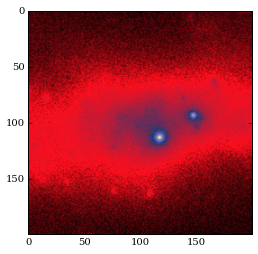

In [56]:
plt.imshow(image, cmap='gist_stern')

It is possible to choose the range of plotted data by modifying the `vmin` and `vmax` parameters:

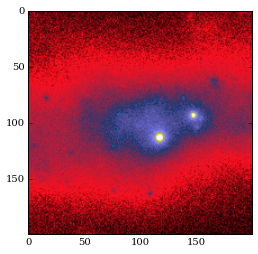

In [57]:
plt.imshow(image, cmap='gist_stern', vmin=image.min()*2, vmax=image.max()/2.)

By default, the color scale is linear but you can set another one thanks to the argument `norm` that takes in input an object from the library `matplotlib.colors` ([documentation](http://matplotlib.org/api/colors_api.html)): `LogNorm`, `PowerNorm(gamma=2)` (or `gamma=0.5` to get a SQRT scale), etc.

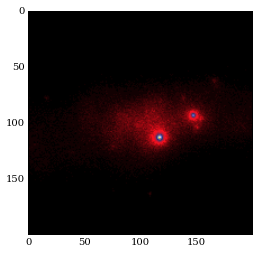

In [40]:
from matplotlib.colors import PowerNorm

plt.imshow(image, cmap='gist_stern', norm=PowerNorm(gamma=2))

In a few lines, we have been able to visualize our data. However, you may have noticed that the **$x$ and $y$ coordinates are not physical as they just represent the pixel values**. So we will continue playing with these modules to get a nice image in the end.

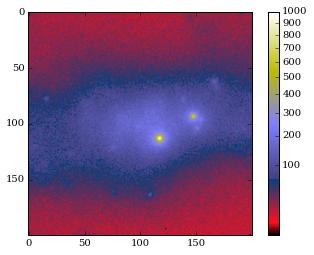

<function __main__.plotim>

In [41]:
#Let's combine what you've learned before !
from matplotlib.colors import PowerNorm
from IPython.html.widgets import interact, fixed

def plotim(im=image, vmax=1000, gamma=0.5):
   plt.imshow(im, cmap='gist_stern', vmax=vmax, norm=PowerNorm(gamma=gamma))
   plt.colorbar()
   plt.show()

interact(plotim, im=fixed(image), vmax=(0,1000), gamma=(0.5,2))  # fixed says don't create a slider for that param

### Represent the Real Coordinates
We will use for that puprpose the package [WCSAxes](http://wcsaxes.readthedocs.org/en/latest/) affiliated with the `Astropy` project. You should have installed this module at the beginning tf the tutorial, if not, just type in the terminal: `pip install wcsaxes`. We then create a figure using Matplotlib and define the axes with the WCS object. This object is an input for the `projection` keyword of the `add_axes` method.

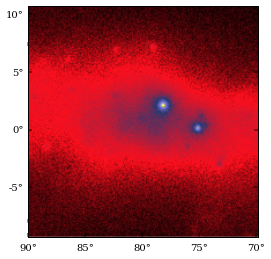

In [42]:
from wcsaxes import WCS # or just 'from astropy.wcs import WCS'

wcs = WCS(header) # read coordinates from FITS header

fig = plt.figure() # initialize the figure environment
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs) # use physical coordinates
ax.imshow(image, cmap='gist_stern', origin='lower')

It starts to look right, but there are a few things to do in order to publish this figure... :)
For example, add a colorbar to give a meaning to the colours, insert a grid and axis labels.

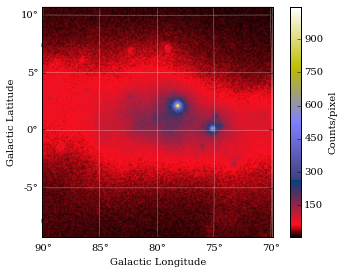

In [43]:
fig = plt.figure() # initialize the figure environment
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs) # use physical coordinates
p = ax.imshow(image, cmap='gist_stern', origin='lower')
cbar = fig.colorbar(p)
cbar.set_label('Counts/pixel')

lon = ax.coords['glon'] # axis objects
lat = ax.coords['glat']

lon.set_axislabel('Galactic Longitude')
lat.set_axislabel('Galactic Latitude')
lon.grid(color='white', alpha=0.5, linestyle='solid')
lat.grid(color='white', alpha=0.5, linestyle='solid')

### Overlaying Coordinate Systems
The `axes` method `get_coords_overlay()` allows one to represent the image into another coordinates system (such as 'galactic', 'fk4', 'fk5', 'icrs' etc.):

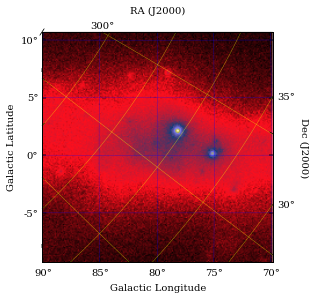

In [44]:
fig = plt.figure() # initialize the figure environment
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs) # use physical coordinates
ax.imshow(image, cmap='gist_stern', origin='lower')

lon = ax.coords['glon'] # axis objects
lat = ax.coords['glat']

lon.set_axislabel('Galactic Longitude')
lat.set_axislabel('Galactic Latitude')
lon.grid(color='blue', alpha=0.5, linestyle='solid')
lat.grid(color='blue', alpha=0.5, linestyle='solid')

# Overlay a FK5 grid coordinates
ra, dec = ax.get_coords_overlay('fk5')
ra.set_axislabel('RA (J2000)')
dec.set_axislabel('Dec (J2000)')
ra.grid(color='yellow', alpha=0.5, linestyle='solid')
dec.grid(color='yellow', alpha=0.5, linestyle='solid')

*You can also see [some examples](http://nbviewer.ipython.org/gist/astrofrog/9183554) of how to use the `wcsaxes` package.* 

### Convolution and Contours

<matplotlib.contour.QuadContourSet instance at 0x1143d6638>

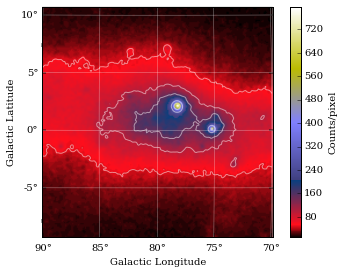

In [45]:
from astropy.convolution import Gaussian2DKernel, convolve
gauss = Gaussian2DKernel(stddev=1)

convolved_image=convolve(image, gauss, boundary='extend')


fig = plt.figure() # initialize the figure environment
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs) # use physical coordinates
p = ax.imshow(convolved_image, cmap='gist_stern', origin='lower')
cbar = fig.colorbar(p)
cbar.set_label('Counts/pixel')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.set_axislabel('Galactic Longitude')
lat.set_axislabel('Galactic Latitude')
lon.grid(color='white', alpha=0.5, linestyle='solid')
lat.grid(color='white', alpha=0.5, linestyle='solid')

# levels=np.linspace(image.min(), image.max(), 10)
ax.contour(convolved_image, levels=[50, 100, 150, 300, 500], colors='white', alpha=0.5)

### Include Catalogue Informations
The last step before saving our figure is to overplot the Fermi-LAT 3FGL source positions that we have previsously selected (**`psr_gal` and `RoI`**). We will have to transform the astronomical coordinates into figure coordinates by using `get_transform` which can be called in many `matplotlib` methods. 

NameError: name 'psr_gal' is not defined

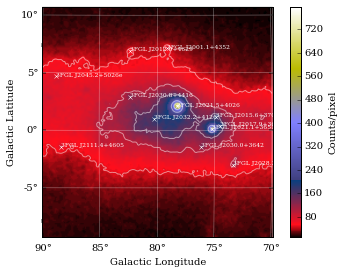

In [59]:
fig = plt.figure() # initialize the figure environment
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs) # use physical coordinates
p = ax.imshow(convolved_image, cmap='gist_stern', origin='lower')

cbar = fig.colorbar(p)
cbar.set_label('Counts/pixel')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.set_axislabel('Galactic Longitude')
lat.set_axislabel('Galactic Latitude')
lon.grid(color='white', alpha=0.5, linestyle='solid')
lat.grid(color='white', alpha=0.5, linestyle='solid')

ax.contour(convolved_image, levels=[50, 100, 150, 300, 500], colors='white', alpha=0.5)

tr_gal = ax.get_transform("galactic") # Transform coordinates into pixels'

for source in RoI:
    x, y = source['GLON'], source['GLAT']
    ax.plot(x, y, color='white', marker='x', markersize=4, transform=tr_gal)
    ax.text(x, y, source['Source_Name'], color='white', size=6, transform=tr_gal)

# Overplot the distribution of pulsars that we found earlier with Simbad
ax.plot(psr_gal.l.degree, psr_gal.b.degree, marker='*', color='green',
        alpha=0.5, linestyle='', transform=tr_gal)

fig.savefig('CygX-3.pdf', bbox_inches='tight')

Of course, there are many ways of getting this result. One of the most popular require the use of [APLpy](https://aplpy.readthedocs.org/en/stable/) which is a great module, very easy to use. Here is the full [list](http://www.astropython.org/resources) of Python resources for astronomers.

## Breakout Session
You will have some time to apply what we have just learned. Here is the exercise, have fun!

Write a small code to save a 'ready-to-publish' `pdf` image. Your code should:
* Compute the **residual image** from the files `CygX-3_FermiLAT.fits` (**data**) and `CygX-3_Model.fits` (**model**) which obeys the equation: $residuals = (data-model)/\sqrt{model}$;
* Convolve the image (take `stddev=2`);
* Plot the residual image:
    * project the image in the correct coordinates system;
    * add axis labels, a black grid and a colorbar (label: 'Residual $\sigma$/pixel');
* Use the FITS informations to query Simbad and return all the sources located in the central image square (length=75% image size) from the '2FGL' catalogue;
* Plot crosses at the source positions along with their names;
* Save the plot as 'breakout_plot.pdf'.